In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import csv
import math

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, precision_recall_curve, classification_report

In [73]:
FILE_PATH = '../data/TeleCom_Data-1.csv'

def format_row(row):
    # format row in the raw data file
    row = row[0]
    row = row.replace('"','')
    row = row.split(';')
    return row

def read_raw_data(file_path='TeleCom_Data-1.csv'):
    '''
    since the raw csv file cannot be read directly by the pandas read_csv function,
    we need to read it in another way and return a dataframe from it.
    '''
    with open(file_path, newline='') as f:
        # data is a list, each element is a row from the file, each row is a list with len 1
        data = csv.reader(f)

        # read the first
        header = next(data)
        header = format_row(header)

        new_data = []

        for row in data:
            row = format_row(row)
            new_data.append(row)

        # create a dict with keys are headers and values are columns
        data_dict = defaultdict(list)

        for row in new_data:
            for i in range(len(row)):
                data_dict[header[i]].append(row[i])

    return pd.DataFrame(data=data_dict)

# read generated data
df = read_raw_data(file_path=FILE_PATH)

print('Data shape:', df.shape)
print(df.columns)
df.head(3)

Data shape: (41180, 21)
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


# Data Preprocessing

## Drop Duplicated

In [74]:
# drop duplicate samples
print('Number of duplicate samples:', len(df[df.duplicated()]))
df = df.drop_duplicates(keep='first')
print('Number of samples after removing duplicate samples:', len(df))

Number of duplicate samples: 12
Number of samples after removing duplicate samples: 41168


# Machine Learning Models

## Train Test Split

In [75]:
X = df.drop(columns='y')
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (32934, 20)
y train shape: (32934,)
X test shape: (8234, 20)
y test shape: (8234,)


/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and

Text(0.5, 1.0, 'y distribution in Test Set')

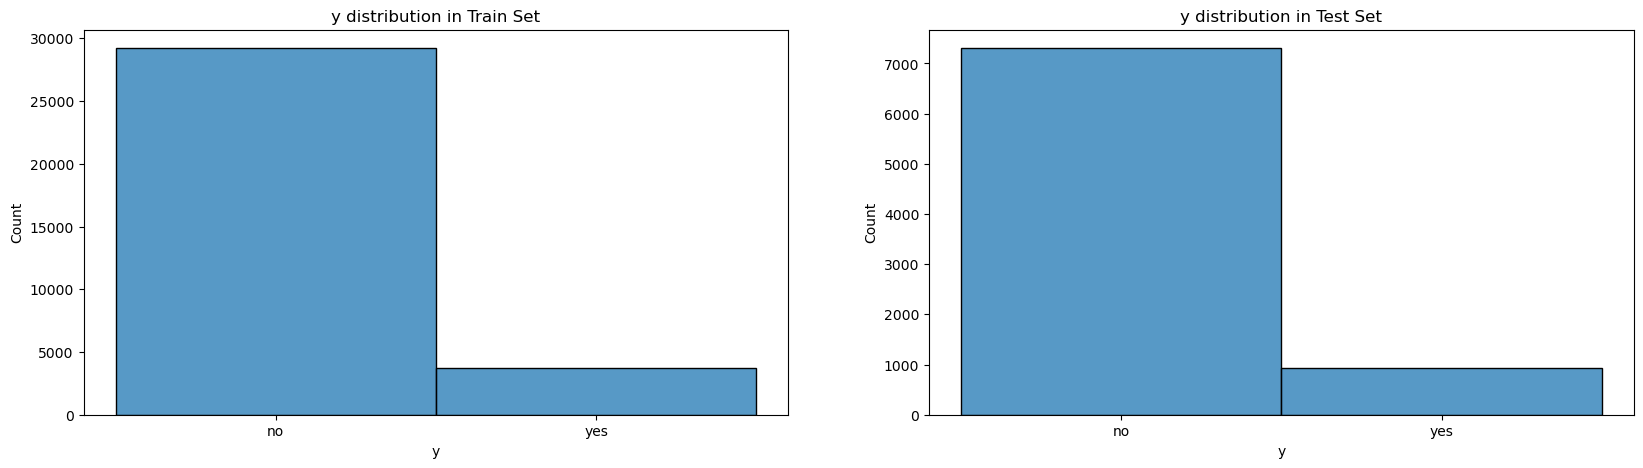

In [7]:
# plot y distribution in train set and test set

fig, axes = plt.subplots(1, 2, figsize=(20,5))
sns.histplot(y_train, ax=axes[0])
axes[0].set_title('y distribution in Train Set')
sns.histplot(y_test,  ax=axes[1])
axes[1].set_title('y distribution in Test Set')

## Feature Selection

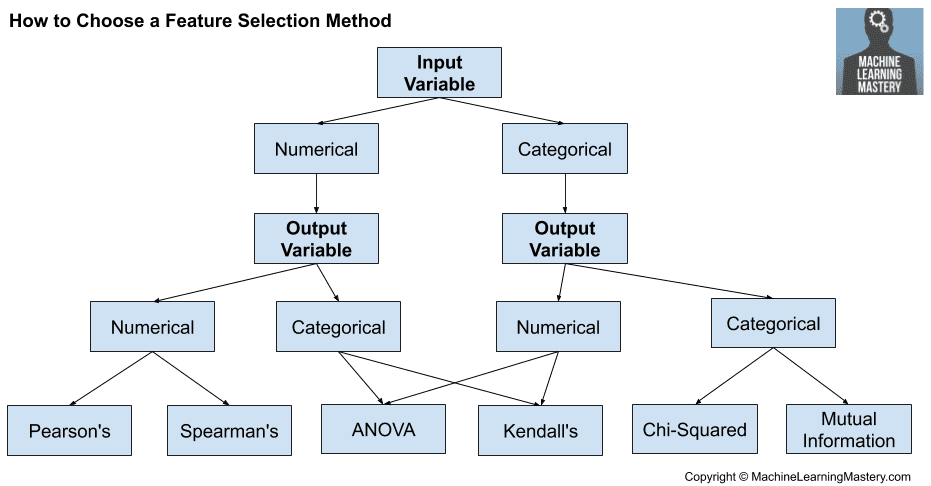

In [9]:
# corr_matrix = df.corr()

# fig, ax = plt.subplots(figsize=(10,10))
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# sns.heatmap(corr_matrix, fmt=".2", cmap=cmap, square=True, mask=mask,
#             vmax=.3, center=0, linewidths=.5, cbar_kws={"shrink": .5})




# # Set a correlation threshold (you can adjust this value)
# threshold = 0.8

# # Find variable pairs with high correlation
# high_corr_pairs = []

# for i in range(len(corr_matrix.columns)):
#     for j in range(i + 1, len(corr_matrix.columns)):
#         if abs(corr_matrix.iloc[i, j]) > threshold:
#             high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

# # Print variable pairs with high correlation
# for var1, var2 in high_corr_pairs:
#     print(f'High correlation between {var1} and {var2}: {corr_matrix.loc[var1, var2]:.3f}')

## Hanlding imbalance with SMOTE NC

In [10]:
from imblearn.over_sampling import SMOTENC

cate_feats = ["job", "marital", "education", "default", "housing", "loan",
            "contact", "month", "day_of_week", "poutcome"]

cate_indices = [X_train.columns.get_loc(feat) for feat in cate_feats]

num_no = (y_train== 'no').sum()
num_yes = (y_train== 'yes').sum()

print('Number of No class:', num_no)
print('Number of Yes class:', num_yes)
print('Yes/No Ratio:', round(num_yes/num_no*100, 2))

smote_nc = SMOTENC(random_state=42, categorical_features=cate_indices)
X_train_balanced, y_train_balanced = smote_nc.fit_resample(X_train, y_train)

Number of No class: 29224
Number of Yes class: 3710
Yes/No Ratio: 12.7


In [11]:
num_no_balanced = (y_train_balanced == 'no').sum()
num_yes_balanced = (y_train_balanced == 'yes').sum()
print('Number of No class:', num_no_balanced)
print('Number of Yes class:', num_yes_balanced)
print('Yes/No Ratio:', round(num_yes_balanced/num_no_balanced*100, 2))

Number of No class: 29224
Number of Yes class: 29224
Yes/No Ratio: 100.0


In [15]:
cate_feats = ["job", "marital", "education", "default", "housing", "loan",
            "contact", "month", "day_of_week", "poutcome", "y"]

def get_encode_cate_dict(df, cate_feats):
    encode_dict = {}
    for feat in cate_feats:
        vals = df[feat].unique()
        encode = {cat_val: encode_val for (encode_val, cat_val) in enumerate(vals)}
        # replace values in df
        encode_dict[feat] = encode
    return encode_dict

encode_dict = get_encode_cate_dict(df, cate_feats)
encode_dict.keys()

dict_keys(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y'])

In [29]:
# encode train and test dataset

def encode_cate_data(df, encode_dict, type='input'):
    if type == 'output':
        df = df.map(encode_dict['y'])
        return df

    for feat in encode_dict.keys():
        if feat == 'y':
            continue
        df[feat] = df[feat].map(encode_dict[feat])
    return df

X_train = encode_cate_data(X_train, encode_dict)
y_train = encode_cate_data(y_train, encode_dict, type='output')

X_train_balanced = encode_cate_data(X_train_balanced, encode_dict)
y_train_balanced = encode_cate_data(y_train_balanced, encode_dict, type='output')

X_test = encode_cate_data(X_test, encode_dict)
y_test = encode_cate_data(y_test, encode_dict, type='output')

Evaluation Metrics: Precision, Recall, F1, ROC, AUC

## Parametric Models

### Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression().fit(X_train, y_train)
log_reg_preds = log_reg.predict(X_test)

print(classification_report(y_test, log_reg_preds, target_names=['no', 'yes']))

log_reg_bl = LogisticRegression().fit(X_train_balanced, y_train_balanced)
log_reg_preds_bl = log_reg_bl.predict(X_test)

print(classification_report(y_test, log_reg_preds_bl, target_names=['no', 'yes']))

/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

          no       0.93      0.98      0.95      7307
         yes       0.68      0.40      0.50       927

    accuracy                           0.91      8234
   macro avg       0.80      0.69      0.73      8234
weighted avg       0.90      0.91      0.90      8234

              precision    recall  f1-score   support

          no       0.98      0.85      0.91      7307
         yes       0.43      0.86      0.57       927

    accuracy                           0.86      8234
   macro avg       0.71      0.86      0.74      8234
weighted avg       0.92      0.86      0.88      8234



/Users/hainguyen/anaconda3/envs/telecom/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Non-parametric Models

### Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier().fit(X_train, y_train)
decision_tree_preds = decision_tree.predict(X_test)

print(classification_report(y_test, decision_tree_preds, target_names=['no', 'yes']))

decision_tree_bl = DecisionTreeClassifier().fit(X_train_balanced, y_train_balanced)
decision_tree_preds_bl = decision_tree_bl.predict(X_test)

print(classification_report(y_test, decision_tree_preds_bl, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.94      0.94      0.94      7307
         yes       0.51      0.52      0.52       927

    accuracy                           0.89      8234
   macro avg       0.73      0.73      0.73      8234
weighted avg       0.89      0.89      0.89      8234

              precision    recall  f1-score   support

          no       0.95      0.93      0.94      7307
         yes       0.52      0.59      0.55       927

    accuracy                           0.89      8234
   macro avg       0.73      0.76      0.75      8234
weighted avg       0.90      0.89      0.90      8234



### Random Forest

In [59]:
from hyperopt import fmin, tpe, hp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 2, 20, 1),
    'min_samples_split': hp.uniform('min_samples_split', 0, 1),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
}


def rf_objective(params):
    # Ensure 'max_depth' is an integer
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])

    # Instantiate a Random Forest classifier with hyperparameters
    random_forest = RandomForestClassifier(n_estimators=params['n_estimators'],
                                max_depth=params['max_depth'],
                                min_samples_split=params['min_samples_split'],
                                min_samples_leaf=params['min_samples_leaf'],
                                max_features=params['max_features'])
    
    # score = cross_val_score(random_forest, X_train, y_train, cv=5, scoring='f1_macro').mean()
    random_forest.fit(X_train, y_train)
    preds = random_forest.predict(X_test)
    score = f1_score(y_test, preds)

    return -score

rf_best_params = fmin(fn=rf_objective, space=space, algo=tpe.suggest, max_evals=100)
print("Best Hyperparameters:")
print(rf_best_params)

100%|██████████| 100/100 [00:56<00:00,  1.78trial/s, best loss: -0.0]
Best Hyperparameters:
{'max_depth': 14.0, 'max_features': 1, 'min_samples_leaf': 0.18627975474717146, 'min_samples_split': 0.9799164162378826, 'n_estimators': 120.0}


In [67]:
# random_forest_best = RandomForestClassifier(
#     n_estimators=int(rf_best_params['n_estimators']),
#     max_depth=int(rf_best_params['max_depth']),
#     min_samples_split=rf_best_params['min_samples_split'],
#     min_samples_leaf=rf_best_params['min_samples_leaf'],
#     max_features=None
# )

random_forest_best = RandomForestClassifier(
    n_estimators=int(rf_best_params['n_estimators']),
    max_depth=int(rf_best_params['max_depth']),
    min_samples_split=2,
    min_samples_leaf=2,
    max_features=None
)

random_forest_best.fit(X_train_balanced, y_train_balanced)
rf_preds_best = random_forest_best.predict(X_test)

print(classification_report(y_test, rf_preds_best, target_names=['no', 'yes']))

random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)
rf_preds = random_forest.predict(X_test)

print(classification_report(y_test, rf_preds, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.96      0.92      0.94      7307
         yes       0.55      0.72      0.62       927

    accuracy                           0.90      8234
   macro avg       0.76      0.82      0.78      8234
weighted avg       0.92      0.90      0.91      8234

              precision    recall  f1-score   support

          no       0.94      0.97      0.95      7307
         yes       0.67      0.51      0.58       927

    accuracy                           0.92      8234
   macro avg       0.80      0.74      0.77      8234
weighted avg       0.91      0.92      0.91      8234



In [66]:
# from sklearn import tree

# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(decision_tree, 
#                    feature_names=X_train.columns,  
#                    class_names=['no', 'yes'],
#                    filled=True)

# decision_tree.get_params()
random_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Gradient Boosting

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

grad_boost = GradientBoostingClassifier().fit(X_train, y_train)
grad_boost_preds = grad_boost.predict(X_test)

print(classification_report(y_test, grad_boost_preds, target_names=['no', 'yes']))

grad_boost_bl = GradientBoostingClassifier().fit(X_train_balanced, y_train_balanced)
grad_boost_preds_bl = grad_boost_bl.predict(X_test)

print(classification_report(y_test, grad_boost_preds_bl, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.94      0.97      0.96      7307
         yes       0.68      0.53      0.60       927

    accuracy                           0.92      8234
   macro avg       0.81      0.75      0.78      8234
weighted avg       0.91      0.92      0.92      8234

              precision    recall  f1-score   support

          no       0.97      0.91      0.94      7307
         yes       0.53      0.79      0.63       927

    accuracy                           0.90      8234
   macro avg       0.75      0.85      0.79      8234
weighted avg       0.92      0.90      0.91      8234

